<a href="https://colab.research.google.com/github/ancestor9/Data-Analyst-with-Gemini-/blob/main/8%EC%9D%BC%EC%B0%A8/1210_04_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAG(Retrieval-Augmented Generation)**
## **검색 증강 생성**
### **검색의 정밀성과 생성의 자연스러움을 결합하여, 복잡한 질문에 대한 정확한 답변을 제공하거나 최신 정보를 활용해야 하는 시스템에서 특히 유용**
<img src = 'https://yozm.wishket.com/media/news/2828/%E1%84%83%E1%85%A1%E1%84%8B%E1%85%AE%E1%86%AB%E1%84%85%E1%85%A9%E1%84%83%E1%85%B3.png'>
<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*J7vyY3EjY46AlduMvr9FbQ.png'>

# <font color='orange'> **chatGPT RAG**

<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*FhMJ8OE_PoeOyeAavYjzlw.png'>

In [ ]:
!pip install langchain_community --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from google.colab import userdata

OPENAI_API_KEY = userdata.get('openapi')
OPENAI_API_KEY = os.getenv(OPENAI_API_KEY) # add your OpenAI API Key

In [ ]:
import requests

# PDF 파일을 다운로드할 URL
# for this example I used Alphabet Inc 10-K Report 2022
url = "https://abc.xyz/assets/43/22/5deefff4fbec54014ae97b340c22/34ac6dab5f586b2e6e008b99fe683e35.pdf"
file_path = "alphabet_10K_2022.pdf"

# PDF 다운로드

# PDF 다운로드
response = requests.get(url)
if response.status_code == 200:
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print(f"파일이 다운로드되었습니다: {file_path}")
else:
    print(f"파일 다운로드에 실패했습니다. 상태 코드: {response.status_code}")

DOC_PATH = "/content/alphabet_10K_2022.pdf"
CHROMA_PATH = "ancestor9_db"


파일이 다운로드되었습니다: alphabet_10K_2022.pdf


In [ ]:
# ----- Data Indexing Process -----
! pip install pypdf --quiet

# load your pdf doc 별첨 파일 load
loader = PyPDFLoader(DOC_PATH)
pages = loader.load()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 3.8 MB/s eta 0:00:00


In [ ]:
print(len(pages))
print(type(pages))

123
<class 'list'>


In [ ]:
pages[0]  # Mongo DB의 Document 형태

Document(metadata={'producer': 'KS - PDF Engine v1', 'creator': 'Chromium', 'creationdate': '2023-02-03T11:16:19+00:00', 'moddate': '2023-02-03T11:16:21+00:00', 'title': 'Form 10-K for Alphabet INC filed 02/03/2023', 'author': 'Kaleidoscope - kscope.io', 'source': '/content/alphabet_10K_2022.pdf', 'total_pages': 123, 'page': 0, 'page_label': '1'}, page_content='UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n___________________________________________\nFORM 10-K\n___________________________________________\n(Mark One)\n☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the fiscal year ended December 31, 2022\nOR\n☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the transition period from              to             .\nCommission file number: 001-37580\n___________________________________________\nAlphabet Inc.\n(Exact name of registrant as specified in its charter)\n______

In [ ]:
# split the doc into smaller chunks i.e. chunk_size=500
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,
                                               chunk_overlap=50)

chunks = text_splitter.split_documents(pages)
print(len(chunks))
print(type(chunks))
chunks[0]

1008
<class 'list'>


Document(metadata={'producer': 'KS - PDF Engine v1', 'creator': 'Chromium', 'creationdate': '2023-02-03T11:16:19+00:00', 'moddate': '2023-02-03T11:16:21+00:00', 'title': 'Form 10-K for Alphabet INC filed 02/03/2023', 'author': 'Kaleidoscope - kscope.io', 'source': '/content/alphabet_10K_2022.pdf', 'total_pages': 123, 'page': 0, 'page_label': '1'}, page_content='UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n___________________________________________\nFORM 10-K\n___________________________________________\n(Mark One)\n☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the fiscal year ended December 31, 2022\nOR\n☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the transition period from              to             .\nCommission file number: 001-37580')

In [ ]:
!pip install chromadb --quiet
!pip install tiktoken --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00

In [ ]:
# get OpenAI Embedding model
OPENAI_API_KEY = userdata.get('openapi')
embeddings = OpenAIEmbeddings(openai_api_key= OPENAI_API_KEY)

# embed the chunks as vectors and load them into the database
db_chroma = Chroma.from_documents(chunks,
                                  embeddings,
                                  persist_directory=CHROMA_PATH)
db_chroma

In [ ]:
# ----- Retrieval and Generation Process -----

# this is an example of a user question (query)
query = 'what are the top risks mentioned in the document?'

# retrieve context - top 5 most relevant (closests) chunks to the query vector
# (by default Langchain is using cosine distance metric)
docs_chroma = db_chroma.similarity_search_with_score(query, k=5)

# generate an answer based on given user query and retrieved context information
context_text = "\n\n".join([doc.page_content for doc, _score in docs_chroma])

# you can use a prompt template
PROMPT_TEMPLATE = """
Answer the question based only on the following context:
{context}
Answer the question based on the above context: {question}.
Provide a detailed answer.
Don’t justify your answers.
Don’t give information not mentioned in the CONTEXT INFORMATION.
Do not say "according to the context" or "mentioned in the context" or similar.
"""

# load retrieved context and user query in the prompt template
prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
prompt = prompt_template.format(context=context_text,
                                question=query)

# call LLM model to generate the answer based on the given context and query
# Pass the OPENAI_API_KEY as a parameter
model = ChatOpenAI(openai_api_key=OPENAI_API_KEY)
response_text = model.predict(prompt)

<ipython-input-15-5376799b3e77>:31: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI(openai_api_key=OPENAI_API_KEY)
<ipython-input-15-5376799b3e77>:32: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response_text = model.predict(prompt)


In [ ]:
print(response_text)

The top risks mentioned in the document are:
1. Interference or interruption from modifications or upgrades, terrorist attacks, state-sponsored attacks, natural disasters or pandemics, geopolitical tensions or armed conflicts, the effects of climate change, power loss, telecommunications failures, computer viruses, software bugs, ransomware.
2. Decrease in the value of investments.
3. Harm to financial condition and operating results.
4. Harm to business, reputation, financial condition, and operating results due to potential legal and financial risks.
5. Loss of users and customers.
6. Compromise of trade secrets.
7. Exposure to legal claims, regulatory actions, fines, and penalties.
8. Harm to business, including product and service offerings, financial condition, and operating results due to successful legal claims.
9. Exposure to potential liabilities, increased costs, and reputational harm related to environmental, social, and governance considerations.
10. Being subject to laws, 

# <font color='orange'> **wrtn RAG**

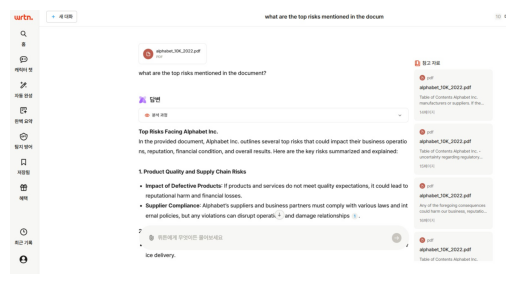

In [ ]:
# prompt: /content/wrtn_RAG_result.jpg 를 시각화

from PIL import Image
import matplotlib.pyplot as plt

try:
  img = Image.open('/content/wrtn_RAG_result.jpg')
  plt.imshow(img)
  plt.axis('off') # Hide axes
  plt.show()
except FileNotFoundError:
  print("Error: Image file not found at /content/wrtn_RAG_result.jpg")
except Exception as e:
  print(f"An error occurred: {e}")

# <font color='orange'> **ChatGPT RAG**

(-0.5, 1896.5, 847.5, -0.5)

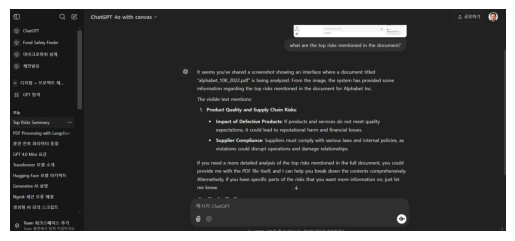

In [ ]:
img = Image.open('/content/chatGPT_RAG_result.jpg')
plt.imshow(img); plt.axis('off')

# <font color='orange'> **Transformer's RAG**

In [ ]:
# 필요한 라이브러리 설치
!pip install transformers faiss-cpu datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 1

In [ ]:
# 필요한 라이브러리 가져오기
from transformers import RagTokenizer, RagRetriever, RagSequenceForGeneration
from datasets import load_dataset
import faiss
import pandas as pd
import numpy as np
import torch

In [ ]:
# 0. 가상데이터 만들기
# 샘플 데이터 생성
data = {
    'id': [1, 2, 3, 4, 5],
    'text': [
        "Artificial Intelligence is transforming various industries, including healthcare and finance.",
        "Natural Language Processing (NLP) is a critical component of AI used for understanding text and speech.",
        "Machine Learning provides systems the ability to automatically learn and improve from experience.",
        "Deep Learning is a subset of machine learning that uses neural networks with many layers.",
        "AI applications include image recognition, language translation, and autonomous driving."
    ]
}
df = pd.DataFrame(data)
df

,id,text
0,1,Artificial Intelligence is transforming variou...
1,2,Natural Language Processing (NLP) is a critica...
2,3,Machine Learning provides systems the ability ...
3,4,Deep Learning is a subset of machine learning ...
4,5,"AI applications include image recognition, lan..."


In [ ]:
# 1. 문서 데이터셋 준비
# 문서 데이터셋 로드 (예시로 CSV 형식의 데이터 파일 사용)
df.to_csv('your_document_dataset.csv', index=False)
dataset = load_dataset('csv', data_files={'train': 'your_document_dataset.csv'})  # 데이터 파일 경로를 변경하세요.
print(dataset)

documents = dataset['train']['text']  # 문서 텍스트 컬럼을 가져옵니다.
print(documents)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text'],
        num_rows: 5
    })
})
['Artificial Intelligence is transforming various industries, including healthcare and finance.', 'Natural Language Processing (NLP) is a critical component of AI used for understanding text and speech.', 'Machine Learning provides systems the ability to automatically learn and improve from experience.', 'Deep Learning is a subset of machine learning that uses neural networks with many layers.', 'AI applications include image recognition, language translation, and autonomous driving.']


**FAISS (Facebook AI Similarity Search)**는 Facebook AI Research에서 개발한 오픈소스 라이브러리로, 대규모 데이터셋에서 벡터 유사도를 매우 빠르고 효율적으로 검색하는 시스템입니다. 주로 벡터화된 문서나 이미지, 사용자 프로필 등을 검색하는 데 사용됩니다.

In [ ]:
# 2. FAISS 인덱스 생성
# 문서 임베딩 생성 (임시로 랜덤 벡터 생성, 실제로는 문서 임베딩 모델로 생성 필요)
# 각 문서를 벡터로 변환하여 인덱스를 만들기 위해 임베딩을 생성합니다.
# 현재는 랜덤 벡터를 생성했지만, 실제로는 문서의 의미를 표현하는 임베딩이 필요합니다.

embedding_dim = 768  # 임베딩 차원
document_embeddings = np.random.random((len(documents), embedding_dim)).astype('float32')  # 실제 임베딩으로 대체 필요
print(document_embeddings)
print(document_embeddings[0].shape)

# FAISS 인덱스 생성 및 문서 추가
# FAISS 인덱스를 생성하여 문서 임베딩을 저장합니다. 이 인덱스를 사용해 문서를 효율적으로 검색할 수 있습니다.
index = faiss.IndexFlatL2(embedding_dim) # L2 거리 기반의 인덱스 생성
print(type(index))

index.add(document_embeddings) # 문서 임베딩을 인덱스에 추가
print(index)

# 인덱스 저장 (옵션)
# 생성한 인덱스를 나중에 재사용하기 위해 파일로 저장합니다.
faiss.write_index(index, "my_faiss_index.index")

[[0.9181306  0.02192259 0.5958796  ... 0.47158965 0.87692404 0.19760883]
 [0.47889015 0.6063219  0.4836419  ... 0.38960496 0.8295217  0.07626608]
 [0.6372147  0.21594259 0.9105468  ... 0.79811114 0.9663426  0.26454905]
 [0.2515898  0.69427824 0.8568711  ... 0.95429015 0.32932135 0.12908427]
 [0.9312811  0.02894513 0.25670958 ... 0.76275545 0.69862443 0.831743  ]]
(768,)
<class 'faiss.swigfaiss_avx2.IndexFlatL2'>
<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7c62534ba6a0> >


In [ ]:
# 3. Hugging Face RAG 모델 및 Retriever 설정
# 모델을 로드하고, 질의에 대해 문서를 검색할 수 있는 Retriever를 설정합니다.
model_name = "facebook/rag-sequence-base"

# Tokenizer, Retriever, 모델 로드
# RAG 모델에서 사용할 토크나이저, 리트리버, 생성 모델을 초기화합니다.
tokenizer = RagTokenizer.from_pretrained(model_name)

# Add 'title' and 'embeddings' columns to the dataset
# Assuming 'document_embeddings' from previous cell holds the embeddings
dataset = dataset.map(lambda example, idx: {'embeddings': document_embeddings[idx], 'title': example['text']}, with_indices=True)

# Add FAISS index to the dataset
dataset['train'].add_faiss_index(column='embeddings')  # Add this line

# Retriever는 문서 인덱스를 사용하여 입력된 질문과 관련된 문서를 검색합니다.
retriever = RagRetriever.from_pretrained(
    model_name,
    index_name="custom", # 커스텀 인덱스를 사용함을 명시
    passages_path=None,  # 외부 경로 대신 이미 로드한 문서 데이터셋을 사용
    indexed_dataset=dataset['train']  # Pass the updated Dataset object
)

# RAG 모델 초기화
# 검색된 문서를 바탕으로 답변을 생성하는 RAG 모델을 초기화합니다.
rag_model = RagSequenceForGeneration.from_pretrained(model_name,
                                                     retriever=retriever)
print(rag_model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizerFast'.


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fr

pytorch_model.bin:   0%|          | 0.00/2.06G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.06G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/rag-sequence-base were not used when initializing RagSequenceForGeneration: ['rag.question_encoder.question_encoder.bert_model.pooler.dense.bias', 'rag.question_encoder.question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing RagSequenceForGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RagSequenceForGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RagSequenceForGeneration(
  (rag): RagModel(
    (question_encoder): DPRQuestionEncoder(
      (question_encoder): DPREncoder(
        (bert_model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0-11): 12 x BertLayer(
                (attention): BertAttention(
                  (self): BertSdpaSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias=True)
                    (key): Linear(in_features=768, out_features=768, bias=True)
                    (value): Linear(in_features=768, out_features=768, bias=True)
                    (dropout): Dropo

In [ ]:
# 4. 질문 입력 및 답변 생성
# 예시 질문
question = "What are the applications of large language models?"

# 질문을 토큰화합니다.
# 질문을 토큰화하여 모델에 입력할 수 있는 형식으로 변환합니다.
input_ids = tokenizer(question, return_tensors="pt").input_ids

# 답변 생성
# 토큰화된 질문을 모델에 입력하여 답변을 생성합니다.
outputs = rag_model.generate(input_ids=input_ids)

# 답변을 텍스트로 디코딩합니다.
generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)

# 생성된 답변 출력
print(generated_text)

['DeepDeep Learning. Deep Learning is a subset of machine learning that uses neural networks with many layers']


In [ ]:
# 5. 최적 하이퍼파라미터 확인 (Optional)
# retriever의 최적화된 파라미터 또는 관련 정보를 확인하고 싶다면 다음과 같은 메서드를 사용할 수 있습니다.
print("Retriever Configuration:", retriever.config)

# You can then access specific parameters:
print("Index name:", retriever.config.index_name)
print("Passage path:", retriever.config.passages_path)
# and other relevant configurations.

Retriever Configuration: RagConfig {
  "architectures": [
    "RagSequenceForGeneration"
  ],
  "dataset": "wiki_dpr",
  "dataset_revision": null,
  "dataset_split": "train",
  "do_deduplication": true,
  "do_marginalize": false,
  "doc_sep": " // ",
  "exclude_bos_score": false,
  "forced_eos_token_id": 2,
  "generator": {
    "_attn_implementation_autoset": false,
    "_name_or_path": "",
    "_num_labels": 3,
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_bias_logits": false,
    "add_cross_attention": false,
    "add_final_layer_norm": false,
    "architectures": [
      "BartModel",
      "BartForMaskedLM",
      "BartForSequenceClassification"
    ],
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classif_dropout": 0.0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": null,
    "d_model": 1024,
    "decoder_attention_heads": 16,
  

### 상세한 주석 추가 설명
- **필요한 라이브러리 설치 및 가져오기**: 이 스크립트는 `transformers`, `faiss`, `datasets` 등의 라이브러리를 사용합니다. 사전 설치해야 하며, 각 라이브러리의 역할은 모델 로딩, 문서 검색, 데이터셋 로드입니다.
- **문서 데이터셋 준비**: `load_dataset()` 함수를 사용해 CSV 파일에서 문서를 로드합니다. 문서 텍스트는 RAG 시스템에서 검색 가능한 데이터로 활용됩니다.
- **FAISS 인덱스 생성**: FAISS는 효율적인 문서 검색을 위해 벡터화된 문서를 저장하고 검색할 수 있는 인덱스를 생성합니다. 여기서 문서 임베딩은 랜덤으로 생성되었지만, 실제 환경에서는 문서의 의미를 잘 표현하는 임베딩을 생성해야 합니다.
- **RAG 모델 및 Retriever 설정**: RAG 시스템은 질문에 대해 관련 문서를 검색하고, 검색된 문서를 바탕으로 답변을 생성하는 모델입니다. 이 과정에서 `retriever`가 FAISS 인덱스를 사용하여 검색 역할을 수행합니다.
- **질문 입력 및 답변 생성**: 사용자가 입력한 질문에 대해 RAG 모델이 응답을 생성합니다. 이 과정은 질문을 토큰화하고, 검색된 문서를 바탕으로 답변을 생성하여 디코딩하는 단계를 포함합니다.

# **Pretrained Model FineTuning**